In [39]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import datetime as dt
import sys
import os
import netCDF4
import pandas as pd
import os.path as osp
import xarray as xr
from copy import copy
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import re
from cartopy.geodesic import Geodesic
import matplotlib
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import string
import datetime
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.io.img_tiles as cimgt
import pytz
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting

pd.options.mode.chained_assignment = None  # default='warn'

In [40]:
figures_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/oct2023/'

# TCCON SBS

In [41]:
#Load the EM27 Data
em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/summer_2023/elaine_retrievals/ua/"

dt1_str = '2023-05-16 00:00:00'
dt2_str =  '2023-05-19 10:00:00'
tz = 'UTC'

oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)

em27_df_sub = em27_df[['xch4(ppm)','xch4(ppm)_error','xco2(ppm)','xco2(ppm)_error','xco(ppb)','xco(ppb)_error','xluft','xluft_error']]
for col in em27_df_sub.columns:
    new_col_name = col.replace('(ppm)','')
    new_col_name = new_col_name.replace('(ppb)','')
    new_col_name = new_col_name+'_em27'
    em27_df_sub = em27_df_sub.rename(columns={col:new_col_name})

## Load the TCCON data into a dataframe

# Point to the TCCON netcdf we want to read
tccon_data_fullpath = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/TCCON/ci20230502_20230701.private.nc'
f = netCDF4.Dataset(tccon_data_fullpath)

# format the time 
time = f.variables['time']
datetimes = netCDF4.num2date(time[:], time.units)
datetimes = [date.strftime('%Y-%m-%d %H:%M:%S') for date in datetimes]

# list the variables you want to keep
cols = ['lat', 'long','xco2','xco2_error','xco','xco_error','xch4','xch4_error','xluft','xluft_error']

# extract those variables from the netcdf and append together
list_nc = []
for c in cols:
    list_nc.append(list(f.variables[c][:]))
    
# convert into pandas dataframe
tccon_df = pd.DataFrame(list_nc)
tccon_df = tccon_df.T # transpose the dataframe
tccon_df.columns = cols # set column names

# add the time as the dataframe index 
tccon_df.index = pd.to_datetime(datetimes, utc = True)

#trim the tccon df to the range of data in the em27 df
tccon_df_sub = tccon_df.loc[(tccon_df.index>=min(em27_df.index))&(tccon_df.index<=max(em27_df.index))]
tccon_df_sub = tccon_df_sub[['xch4','xch4_error','xco2','xco2_error','xco','xco_error','xluft','xluft_error']]
for col in tccon_df_sub.columns:
    new_col_name = col+'_tccon'
    tccon_df_sub = tccon_df_sub.rename(columns={col:new_col_name})

In [42]:
resample_interval = '10T'
clip_range = ['2023-05-16 20:00:00','2023-05-19 00:00:00']
em27_df_resampled = em27_df_sub.resample(resample_interval).mean(numeric_only=True)
tccon_df_resampled = tccon_df_sub.resample(resample_interval).mean(numeric_only=True)
merged_df = pd.concat([em27_df_resampled,tccon_df_resampled],axis = 1)
merged_df = merged_df.loc[(merged_df.index>=clip_range[0])&(merged_df.index<=clip_range[1])]
merged_df = merged_df.dropna()

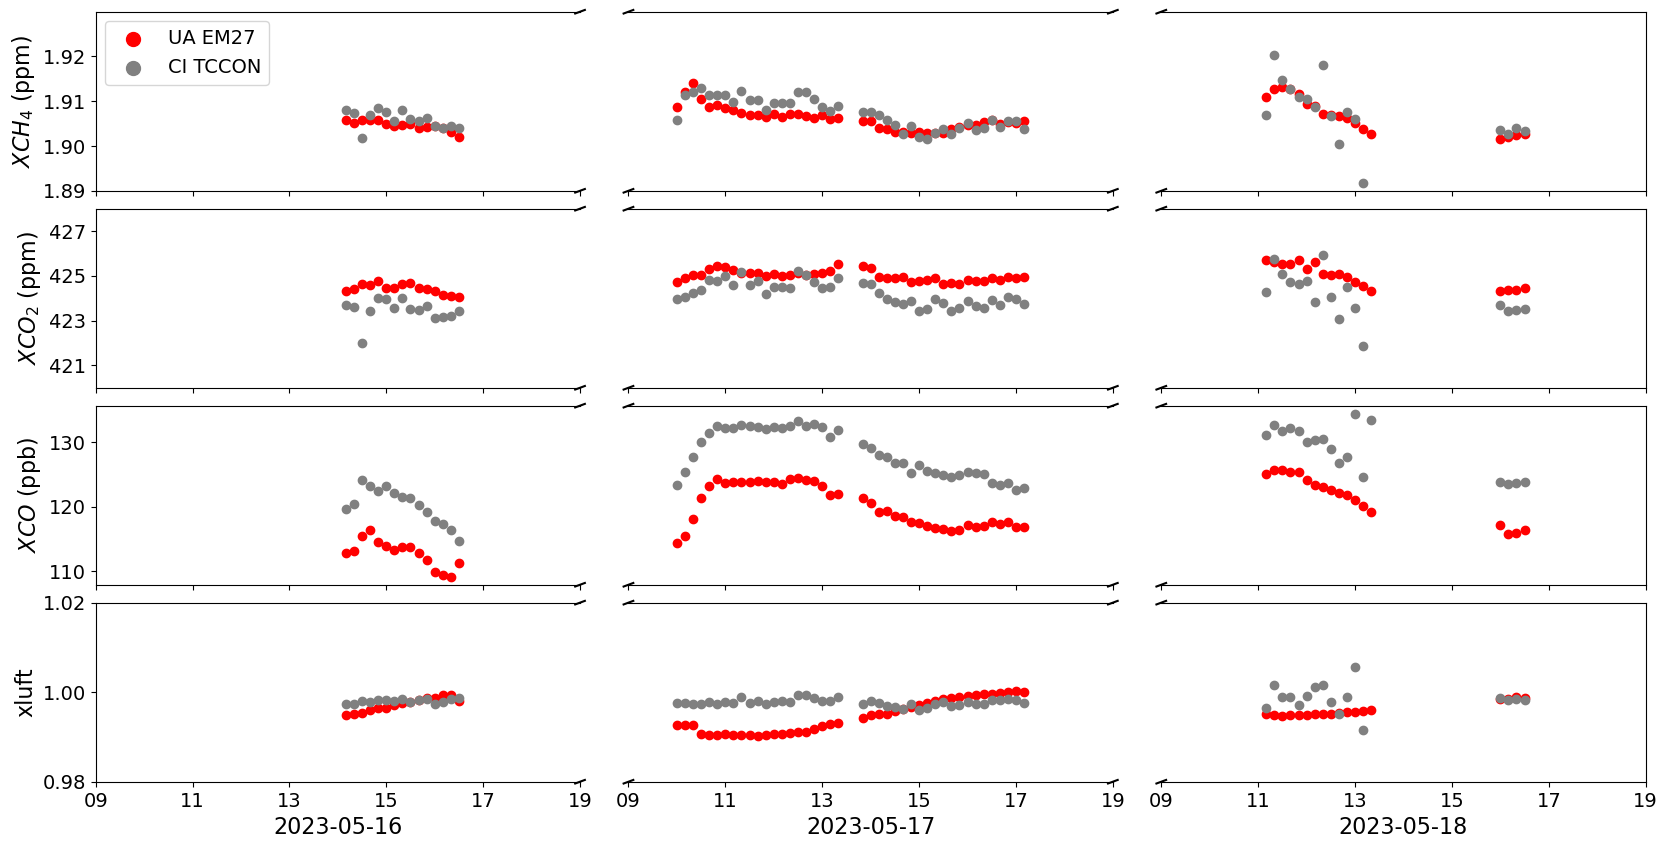

In [43]:
fig_id = 'em27_tccon_sbs_luft'
broken_dtranges = [[pd.to_datetime('2023-05-16 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-16 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-17 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-17 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-18 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-18 18:00:00').tz_localize('US/Pacific')]]


fig,axes = plt.subplots(4,len(broken_dtranges),figsize = (20,10))
labsize = 16
d= 0.01
plot_df = merged_df.copy()
plot_df.index = plot_df.index.tz_convert('US/Pacific')


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([1.89,1.93])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_tccon'],color = 'grey')
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 3
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([0.98,1.02])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('xluft',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

axes[0][0].scatter([],[],color = 'red',label = 'UA EM27',s = 100)
axes[0][0].scatter([],[],color = 'grey',label = 'CI TCCON',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 2)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

In [44]:
specs = ['xch4','xco2','xco','xluft']
tccon_ua_diff_dict = {}
for spec in specs:
    merged_df[f'{spec}_diff'] = merged_df.apply(lambda row: row[f'{spec}_tccon']-row[f'{spec}_em27'],axis = 1)
    tccon_ua_diff_dict[spec] = dict(merged_df[f'{spec}_diff'].describe())
tccon_ua_diff_dict

{'xch4': {'count': 75.0,
  'mean': 0.002423698609672682,
  'std': 0.012280470890963922,
  'min': -0.012109092087581264,
  '25%': -0.00010854968624340877,
  '50%': 0.0014531283727505784,
  '75%': 0.0024946397729567193,
  'max': 0.10442496948242197},
 'xco2': {'count': 75.0,
  'mean': -0.5685790046311839,
  'std': 2.490528905558594,
  'min': -2.694020954000564,
  '25%': -1.0714125976562627,
  '50%': -0.835439422984166,
  '75%': -0.6018618701599507,
  'max': 20.258756103515623},
 'xco': {'count': 75.0,
  'mean': 7.876710989967739,
  'std': 1.5845583798819727,
  'min': 3.392286194918455,
  '25%': 6.978228494883616,
  '50%': 8.217048023365166,
  '75%': 8.537231456477464,
  'max': 14.173743896484382},
 'xluft': {'count': 75.0,
  'mean': 0.003169949152000517,
  'std': 0.006426685964116104,
  'min': -0.004321825093236531,
  '25%': -0.0004436561182925569,
  '50%': 0.002169104998788751,
  '75%': 0.006225577877555122,
  'max': 0.04910624027252197}}

# EM27 SBS

In [45]:
def merge_oofdfs(oof_dfs,add_tags = False,dropna=False):
    inst_ids = oof_dfs.keys()
    dfs_for_merge = {}
    for inst_id in inst_ids:
        df = oof_dfs[inst_id].copy()
        if add_tags:
            for col in df.columns:
                df = df.rename(columns={col:f'{col}_{inst_id}'})
        dfs_for_merge[inst_id] = df
    merged_df = pd.DataFrame()
    for inst_id in inst_ids:
        merged_df = pd.concat([merged_df,dfs_for_merge[inst_id]],axis = 1)
    if dropna:
        merged_df = merged_df.dropna()
    return merged_df

def read_all_wbb_to_df(wbb_data_path,wbb_resample_interval):
    wbb_met_df = pd.DataFrame()
    for file in os.listdir(wbb_data_path):
        fullpath = os.path.join(wbb_data_path,file)
        df = pd.read_csv(fullpath,header = 6,skiprows=[7])
        df.index = pd.to_datetime(df['Date_Time']).dt.tz_convert(timezone)
        df[['u','v']] = df.apply(lambda row: ac.wdws_to_uv(row['wind_speed_set_1'],row['wind_direction_set_1']),axis = 1,result_type='expand')

        if wbb_resample_interval == None:
            df_resampled = df.copy()
        else:
            df_resampled = df.resample(wbb_resample_interval).mean(numeric_only=True).dropna(how='all')
        df_resampled['ws'],df_resampled['wd'] = np.vectorize(ac.uv_to_wdws)(df_resampled['u'],df_resampled['v'])
        wbb_met_df = pd.concat([wbb_met_df,df_resampled])
    wbb_met_df = wbb_met_df.sort_index()
    wbb_met_df = wbb_met_df.rename(columns={'pressure_set_1':'pressure','air_temp_set_1':'temp'})
    wbb_met_df['pressure'] = wbb_met_df['pressure']/100
    return wbb_met_df

def read_all_trisonica_to_df(trisonica_data_path,trisonica_resample_interval):
    headers_list = ['ET','Date','Time','S','D','U','V','W','T','H','DP','P','AD','PI','RO','MD','TD']
    trisonica_df = pd.DataFrame()
    for file in os.listdir(trisonica_data_path):
        fullpath = os.path.join(trisonica_data_path,file)
        with open(fullpath,'r',errors='ignore') as f:
            rows_list = []
            for i,line in enumerate(f):
                newline = line.strip()
                if len(newline) < 5:
                    continue
                newline = newline.replace('=','')
                for let in string.ascii_letters.replace('n','').replace('a',''):
                    newline = newline.replace(let,'')
                newline = newline.replace(',',' ')
                if newline[0] == ' ':
                    newline = newline[1:]
                newline = re.sub(r"\s+",",",newline)
                line_to_append = newline.split(',')
                if len(line_to_append) == len(headers_list):
                    rows_list.append(line_to_append)
            df = pd.DataFrame(rows_list)
            df.columns = headers_list
            for col in df.columns:
                df[col] = pd.to_numeric(df[col],errors='coerce')
            df = df.dropna(axis = 1,how = 'all')
            df['DT'] = pd.to_datetime(df['ET'],unit='s')
            df = df.set_index('DT')
            df.index = df.index.tz_localize('UTC').tz_convert(timezone)
            df = df.drop(['S','D'],axis = 1)
            if trisonica_resample_interval is not None:
                df = df.resample(trisonica_resample_interval).mean(numeric_only=True)
        trisonica_df = pd.concat([trisonica_df,df])
    trisonica_df = trisonica_df.sort_index()
    trisonica_df['ws'],trisonica_df['wd'] = np.vectorize(ac.uv_to_wdws)(trisonica_df['U'],trisonica_df['V'])
    return trisonica_df

In [46]:
#Define parameters
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
data_subfolder = os.path.join(base_project_dir,'Data/EM27_oof/summer_2023/elaine_retrievals')
inst_ids = ['ha','ua']
flag = 0
resample = 'T'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)','xluft']

## Without TCCON Correction

In [47]:
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    oof_dfs[inst_id] = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone)
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone)
        data_folder = os.path.join(data_subfolder,inst_id)
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
        if flag is not None:
            df = df.loc[df['flag']==flag]
        if resample is not None:
            df = df.resample(resample).mean(numeric_only = True)
        oof_dfs[inst_id] = pd.concat([oof_dfs[inst_id],df])
merged_df = merge_oofdfs(oof_dfs,add_tags=True,dropna=True)

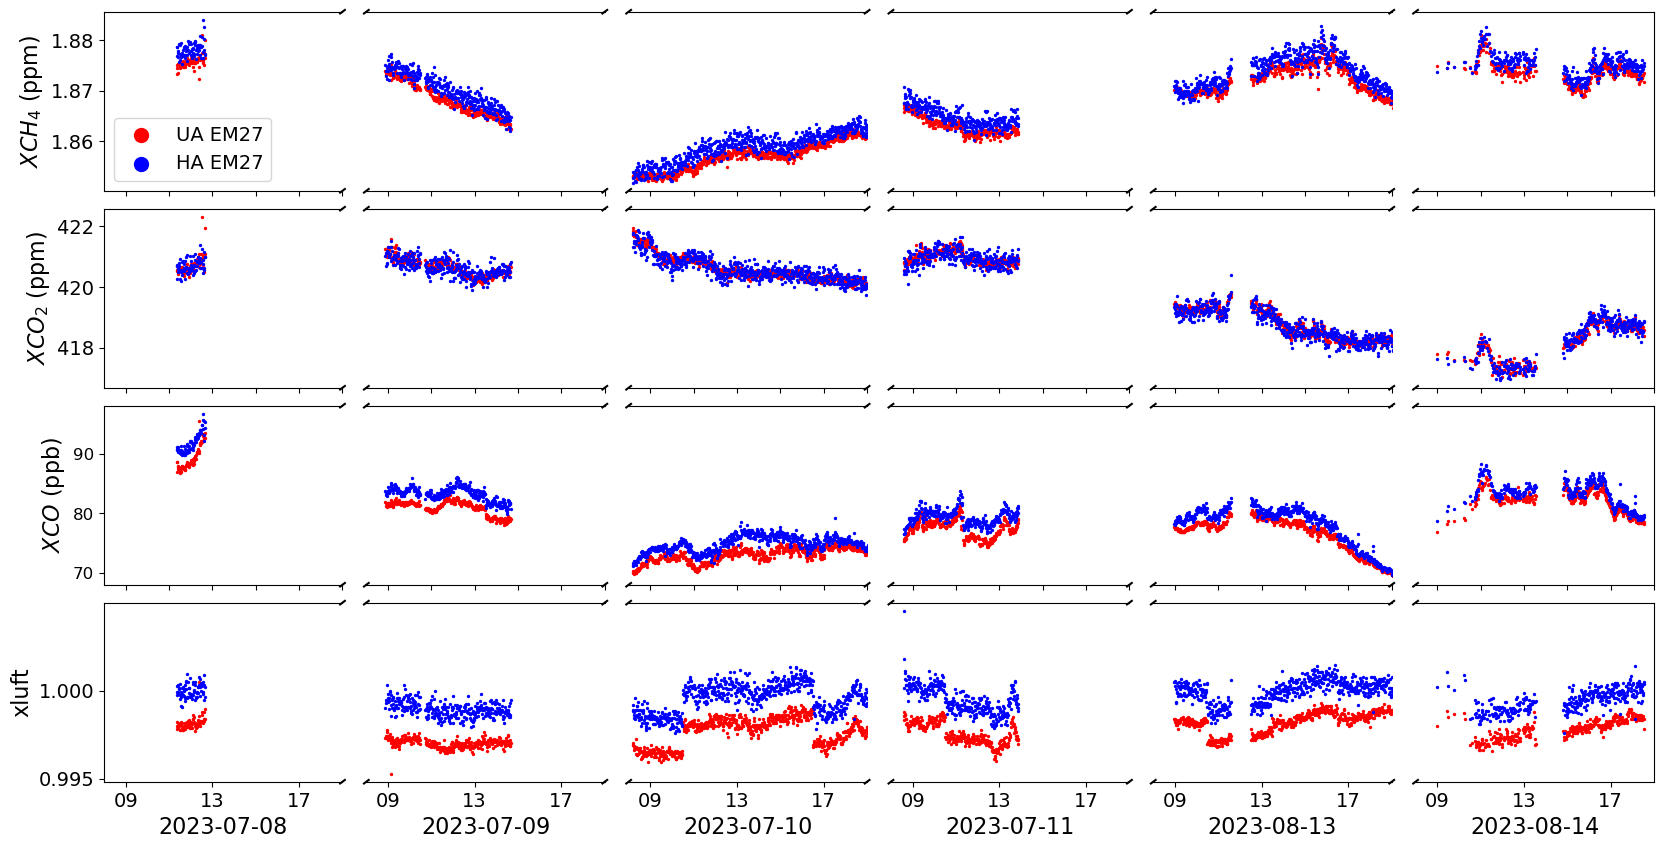

In [48]:
fig_id = 'em27_ha_ua_sbs_nocorr_luft'
broken_dtranges = [[pd.to_datetime('2023-07-08 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-08 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-09 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-09 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-10 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-10 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-11 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-11 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-13 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-13 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-14 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-14 19:00:00').tz_localize(timezone)]]


fig,axes = plt.subplots(4,len(broken_dtranges),figsize = (20,10))
d= 0.01
markersize = 2
plot_df = merged_df.copy()


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_ylim([1.89,1.93])
    #axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ha'],color = 'blue',s = markersize)
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-4)

row = 3
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xluft_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('xluft',size = labsize)
axes[row][0].tick_params(labelsize = labsize-4)

axes[0][0].scatter([],[],color = 'red',label = 'UA EM27',s = 100)
axes[0][0].scatter([],[],color = 'blue',label = 'HA EM27',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 3)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=4))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

## With TCCON Correction